## 练习：分类花朵图像
使用本节课所学内容建立一个带有防止过拟合方法的CNN模型
### 样例
尺寸不同的RGB三通道彩色图片，总共五种类型的花的图片
### 标签
* 0: daisy
* 1: dandelion
* 2: roses
* 3: sunflowers
* 4: tulips

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

In [2]:
#import packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 导入数据
### 下载数据
首先将花朵数据下载到本地，并解压到同文件夹中data路径下。[数据下载链接](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)。解压后的文件目录结构为：
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

之后需要对文件夹中的图片数据进行划分，分成训练集和验证集，其中80%为训练集。使用下面代码对数据进行自动处理，处理后的文件目录结构为：
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>diasy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]   
</pre>

In [3]:
base_dir = os.path.join('data', 'flower_photos')

classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

# for cl in classes:
#     # 对于每一类的图片文件夹
#     img_path = os.path.join(base_dir, cl)
#     # 使用glob.glob()方法获取当前文件夹下匹配参数字符串的所有文件名
#     images = glob.glob(img_path + '/*.jpg')
#     print("{}: {} Images".format(cl, len(images)))
#     train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]
    
#     # 建立对应的训练集和验证集文件目录
#     if not os.path.exists(os.path.join(base_dir, 'train', cl)):
#         os.makedirs(os.path.join(base_dir, 'train', cl))
#     if not os.path.exists(os.path.join(base_dir, 'val', cl)):
#         os.makedirs(os.path.join(base_dir, 'val', cl))
        
#     # 使用shutil.move()方法移动文件
#     for t in train:
#         shutil.move(t, os.path.join(base_dir, 'train', cl))

#     for v in val:
#         shutil.move(v, os.path.join(base_dir, 'val', cl))

In [4]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

### 设置BATCH_SIZE以及IMG_SHAPE
* **BATCH_SIZE**：一个Batch中图片的数量
* **IMG_SHAPE**：首先需要将尺寸不同的图片处理成尺寸相同的图片，这里的``IMG_SHAPE``即处理后的图片高和宽的像素数

In [5]:
BATCH_SIZE = 128
IMG_SHAPE = 224

## 数据增强操作

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Found 2935 images belonging to 5 classes.


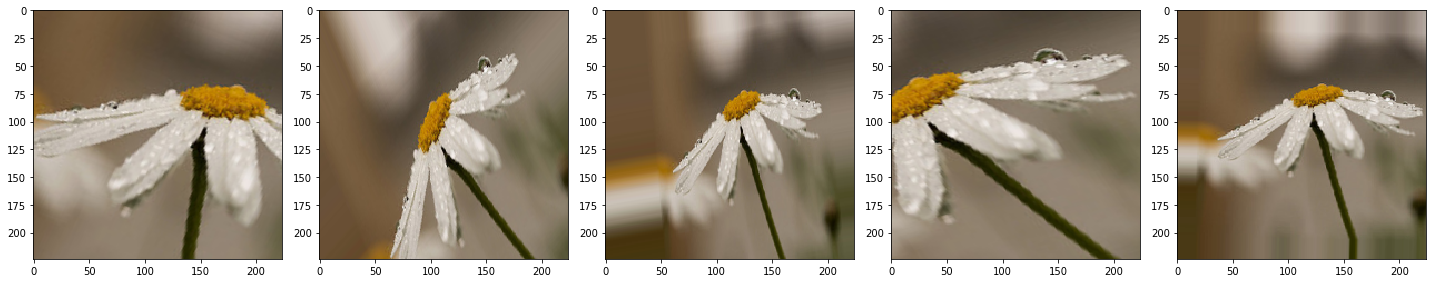

In [7]:
image_gen = ImageDataGenerator(rescale=1./255,
                              rotation_range=45,
                              zoom_range=.5,
                              horizontal_flip=True,
                              width_shift_range=.15,
                              height_shift_range=.15)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='sparse')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [8]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=val_dir,
                                                shuffle=False,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='sparse')
# image_gen_val = ImageDataGenerator(rescale=1./255)
# val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
#                                                 directory=train_dir,
#                                                 shuffle=False,
#                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
#                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


## 构建模型

In [9]:
def depthwise(h, filters, depth_multiplier=1, kernel_size_d=(3,3), strides_d=2, padding_d='same', activation_d='linear', 
                                                      kernel_size_c=(1,1), strides_c=1, padding_c='same', activation_c='linear', t=0):
    layer = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel_size_d, strides=strides_d, padding=padding_d,
                                            depth_multiplier=depth_multiplier, activation=activation_d, 
                                            depthwise_regularizer='l2', bias_regularizer='l2')(h)
    layer = tf.keras.layers.BatchNormalization()(layer, training=True)
    layer = tf.keras.layers.ReLU()(layer)
    layer = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size_c, strides=strides_c, padding=padding_c,
                                   activation=activation_c)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer, training=True)
    layer = tf.keras.layers.ReLU()(layer)
    return layer

In [10]:
tf.keras.backend.set_learning_phase(True)
inputs = tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))
h = tf.keras.layers.Conv2D(32, (3,3), padding='same', strides=2, activation='linear', input_shape=(IMG_SHAPE, IMG_SHAPE, 3))(inputs)
h = tf.keras.layers.BatchNormalization()(h, training=True)
h = tf.keras.layers.ReLU()(h)

h = depthwise(h, strides_d=1, filters=64)
h = depthwise(h, strides_d=2, filters=128)
h = depthwise(h, strides_d=1, filters=128)
h = depthwise(h, strides_d=2, filters=256)
h = depthwise(h, strides_d=1, filters=256)
h = depthwise(h, strides_d=2, filters=512)
h = depthwise(h, strides_d=1, filters=512)
h = depthwise(h, strides_d=1, filters=512)
h = depthwise(h, strides_d=1, filters=512)
h = depthwise(h, strides_d=1, filters=512)
h = depthwise(h, strides_d=1, filters=512)

h = depthwise(h, strides_d=2, filters=1024)
h = depthwise(h, strides_d=2, filters=1024)
h = tf.keras.layers.GlobalAveragePooling2D()(h)
# h = tf.keras.layers.Dense(1000, activation='relu')(h)
h = tf.keras.layers.Flatten()(h)
outputs = tf.keras.layers.Dense(5, activation='softmax')(h)

model = tf.keras.Model(inputs, outputs)

## 编译模型

In [11]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['sparse_categorical_accuracy'])

In [12]:
# 堆叠方法建立的网络
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 32)      0     

## 训练模型

In [13]:
EPOCHS = 200
history = model.fit_generator(train_data_gen,
                             epochs=EPOCHS,
                             steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
                             validation_data=val_data_gen,
                             validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))))

Epoch 1/200
23/23 [==============================] - 369s 16s/step - loss: 1.8445 - sparse_categorical_accuracy: 0.3315 - val_loss: 2.0394 - val_sparse_categorical_accuracy: 0.3034
Epoch 2/200
23/23 [==============================] - 359s 16s/step - loss: 1.5656 - sparse_categorical_accuracy: 0.4569 - val_loss: 2.1979 - val_sparse_categorical_accuracy: 0.3020
Epoch 3/200
23/23 [==============================] - 351s 15s/step - loss: 1.4757 - sparse_categorical_accuracy: 0.5107 - val_loss: 2.4251 - val_sparse_categorical_accuracy: 0.3048
Epoch 4/200
23/23 [==============================] - 351s 15s/step - loss: 1.4003 - sparse_categorical_accuracy: 0.5438 - val_loss: 2.4335 - val_sparse_categorical_accuracy: 0.2844
Epoch 5/200
23/23 [==============================] - 356s 15s/step - loss: 1.3378 - sparse_categorical_accuracy: 0.5632 - val_loss: 2.4484 - val_sparse_categorical_accuracy: 0.2884
Epoch 6/200
23/23 [==============================] - 356s 15s/step - loss: 1.2786 - sparse_cate

KeyboardInterrupt: 

In [15]:
model.get_layer(index=2)

In [14]:
test_loss, test_accuracy = model.evaluate(val_data_gen, steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE))))
print('Loss and accuracy on test dataset: {0:.4f}, {1:.4f}'.format(test_loss, test_accuracy))

6/6 [==============================] - 49s 8s/step - loss: 4.4651 - sparse_categorical_accuracy: 0.3605
Loss and accuracy on test dataset: 4.4651, 0.3605


## 可视化训练结果
将模型在训练集以及测试集上分别得到的不同``epoch``对应的``loss``以及准确率进行可视化。

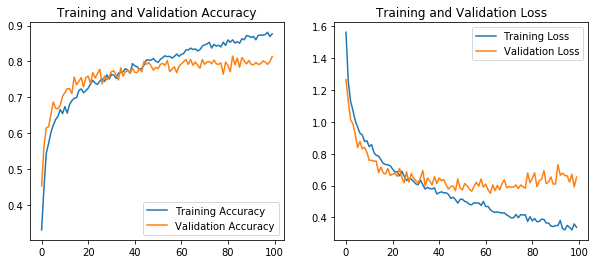

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
#     tf.keras.layers.MaxPool2D(2, 2),
    
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
    
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
    
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(.2),
#     tf.keras.layers.Dense(units=512, activation='relu'),
    
#     tf.keras.layers.Dropout(.2),
#     tf.keras.layers.Dense(units=5, activation='softmax')
# ])

In [24]:
# inputs = tf.keras.Input(shape=(IMG_SHAPE, IMG_SHAPE, 3))
# h = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3))(inputs)
# h = tf.keras.layers.MaxPool2D(2, 2)(h)
    
# h = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(h)
# h = tf.keras.layers.MaxPool2D(2, 2)(h)

# h = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(h)
# h = tf.keras.layers.MaxPool2D(2, 2)(h)

# h = tf.keras.layers.Flatten()(h)
# h = tf.keras.layers.Dropout(.2)(h)
# h = tf.keras.layers.Dense(units=512, activation='relu')(h)

# h = tf.keras.layers.Dropout(.2)(h)
# outputs = tf.keras.layers.Dense(units=5, activation='softmax')(h)

# model = tf.keras.Model(inputs, outputs)